In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('takehome_user_engagement.csv')
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [4]:
df['time_stamp'] = df['time_stamp'].dt.floor('d').astype(np.int64)
df = df.sort_values(['user_id', 'time_stamp']).drop_duplicates()

In [5]:
a = df.groupby('user_id')['time_stamp'].rolling(window=3)
b = pd.to_timedelta((a.max()- a.min())).dt.days
c = b[b < 8].index.get_level_values('user_id').tolist()

In [6]:
adopted_user = np.unique(c)
print(adopted_user)

[    2    10    20 ... 11969 11975 11988]


In [7]:
df1 = pd.read_csv('takehome_users.csv', encoding="ISO-8859-1")
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [8]:
df1['last_session_creation_time'] = pd.to_datetime(df1['last_session_creation_time'], unit='s')
df1['adopted'] =df1.object_id.apply(lambda x: 1 if x in adopted_user else 0)
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [9]:
print("fraction of adopted user: ", len(adopted_user)/len(df1))

fraction of adopted user:  0.138


We already used creation_time, and last_session_creation_time column information when creating the label for adopted users. They should not be included as features for prediction. Also, name and email information cannot be a predictor too. Therefore, I will drop those columns

In [10]:
df1 = df1.drop(['creation_time', 'name', 'email', 'last_session_creation_time'], axis=1)
df1.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,GUEST_INVITE,1,0,11,10803.0,0
1,2,ORG_INVITE,0,0,1,316.0,1
2,3,ORG_INVITE,0,0,94,1525.0,0
3,4,GUEST_INVITE,0,0,1,5151.0,0
4,5,GUEST_INVITE,0,0,193,5240.0,0


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
object_id                     12000 non-null int64
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null int64
dtypes: float64(1), int64(5), object(1)
memory usage: 656.4+ KB


In invited_by_user_id columns, almost half of the values are NaN, so I will drop this column as well(we will lose a lot of information if we drop observation rows for each NaN). Also object_id is a user_id, so this should be also dropped.

In [12]:
df1 = df1.drop(['invited_by_user_id', 'object_id'], axis=1)
df1.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,GUEST_INVITE,1,0,11,0
1,ORG_INVITE,0,0,1,1
2,ORG_INVITE,0,0,94,0
3,GUEST_INVITE,0,0,1,0
4,GUEST_INVITE,0,0,193,0


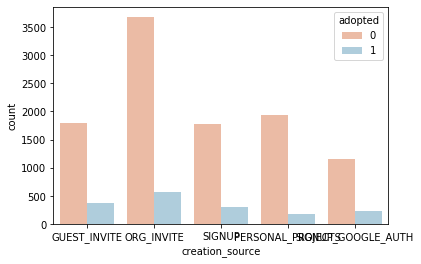

In [13]:
plt.figure()
sns.countplot(x='creation_source', hue='adopted', data=df1, palette='RdBu')
plt.show()

In [14]:
df1 = pd.get_dummies(df1, drop_first=True)
df1.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,0,0,0,0,0
1,0,0,1,1,1,0,0,0
2,0,0,94,0,1,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,193,0,0,0,0,0


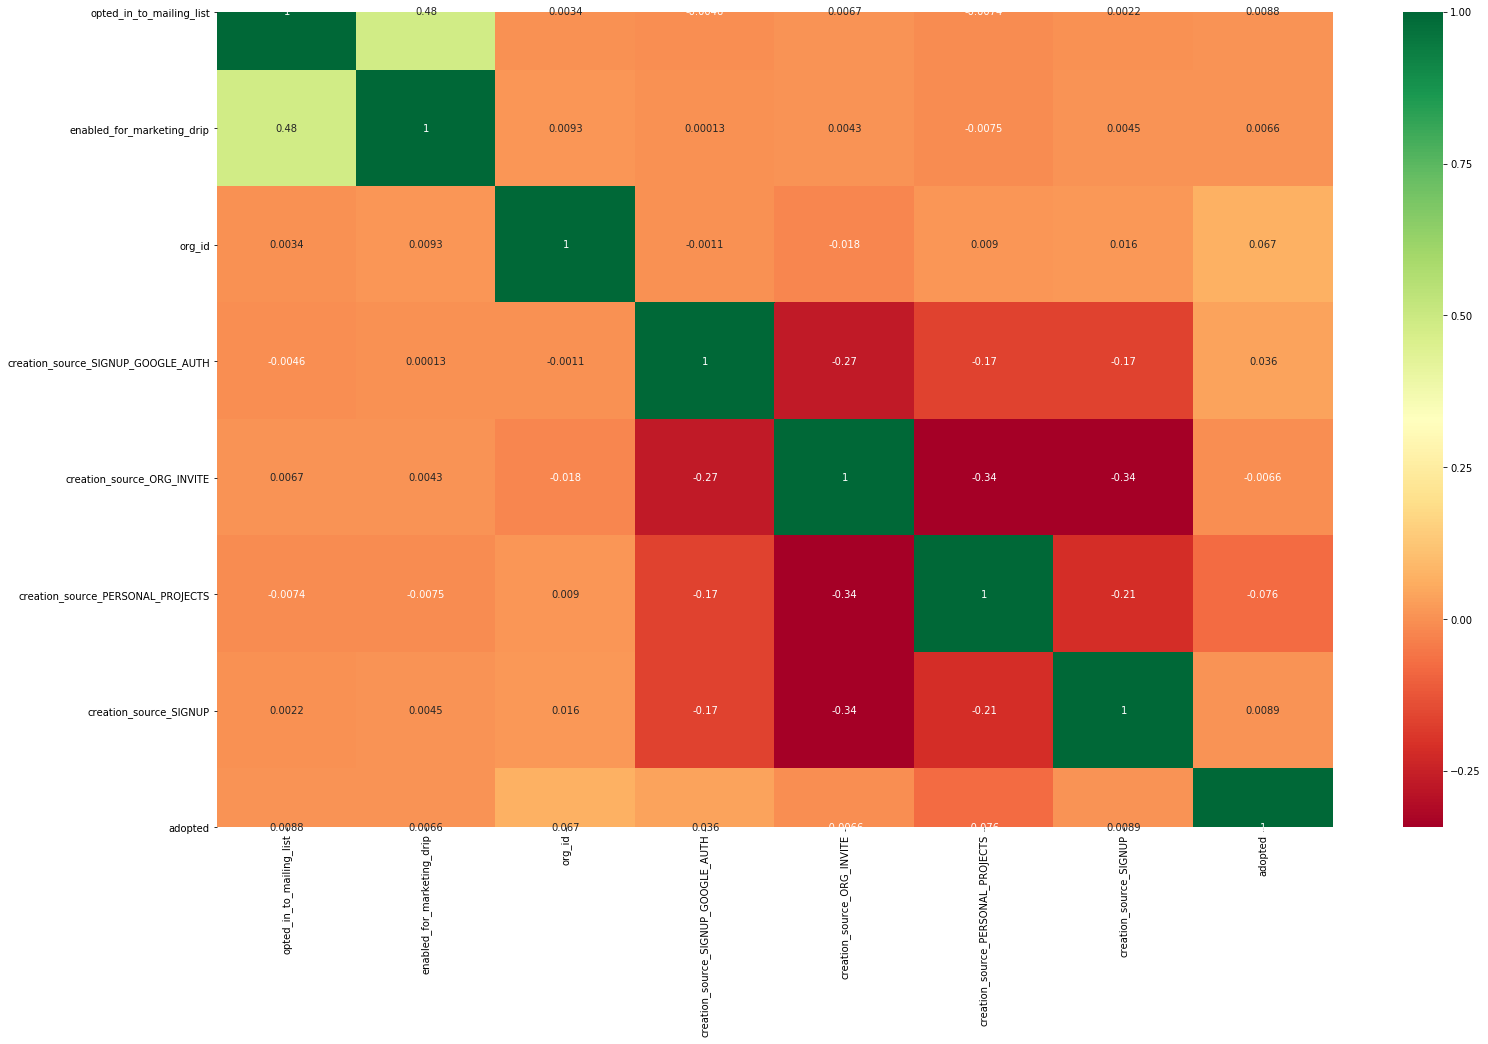

In [15]:
cols = list(df1.columns.values)
cols[3], cols[-1] = cols[-1], cols[3]
df1 = df1[cols]
corrmat = df1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,15))
#plot heat map
g=sns.heatmap(df1[top_corr_features].corr(),annot=True,cmap="RdYlGn")

C:\Users\bluep\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


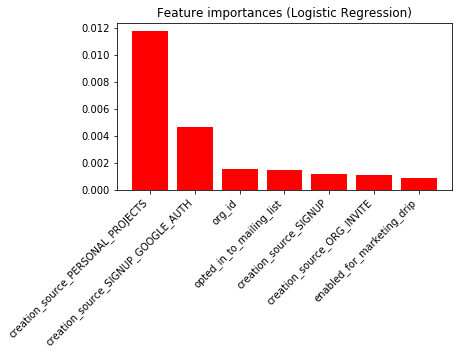

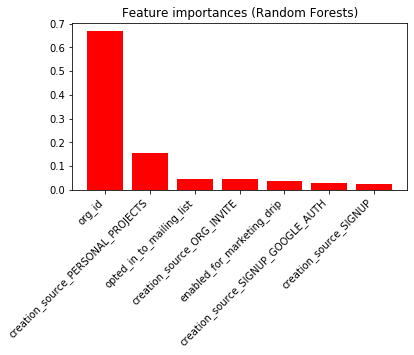

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
X = df1.iloc[:,:-1]
y = df1.iloc[:,-1]
clf = LogisticRegressionCV(max_iter=3000)
clf.fit(X, y)
coefs = np.abs(clf.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(7), coefs[indices[:12]],
       color="r", align="center")
plt.xticks(range(7), df1.columns[indices[:12]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

clf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=400, max_depth=6, max_features=6)
clf.fit(X, y)
coefs = clf.feature_importances_
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Random Forests)")
plt.bar(range(7), coefs[indices[:12]],
       color="r", align="center")
plt.xticks(range(7), df1.columns[indices[:12]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

plt.ion(); plt.show()

When we have many categorical variables for binary classification, random forest classifer will be better, and efficient than other classifiers. Therefore, I would say ord_id, PERSONAL_PROJECTS, and opted_in_to_mailing_list are the three most important factors to predict future user adoption.